**pip 및 import**

⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️

In [1]:
!pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 7.2 MB/s eta 0:00:0000:010:01


In [3]:
!pip install shapely

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.4 MB/s eta 0:00:0000:0100:01


In [4]:
import pandas
# from google.colab import files

import numpy as np
from scipy.spatial import distance_matrix
from gurobipy import *
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
from numpy import random

학원 데이터

⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️

In [37]:
data = pandas.read_csv("../data/학원좌표인원.csv", index_col=0)
data.head()

,학원/교습소,교습과정명,학원명,주소,위도,경도,인원
0,학원,보습,생명을살리는수학창의교육보습학원,서울특별시 광진구 구의강변로 106,37.535520,127.092110,24.0
1,학원,음악,시엘음악학원,서울특별시 광진구 용마산로21길 27,37.562051,127.085027,40.0
2,학원,보습,성신에듀학원,서울특별시 광진구 자양로22길 24,37.539591,127.084841,53.0
3,학원,보습,청람보습학원,서울특별시 광진구 용마산로 100,37.567870,127.086185,90.0
4,학원,보습,상명보습학원,서울특별시 광진구 자양로 181-1,37.544674,127.085019,59.0


In [38]:
data.describe()

,위도,경도,인원
count,782.000000,782.000000,780.000000
mean,37.542324,127.086486,45.882051
std,0.010457,0.009142,51.679087
min,37.527822,127.062410,0.000000
25%,37.534754,127.081352,6.000000
50%,37.539280,127.088359,34.500000
75%,37.546830,127.092110,71.000000
max,37.567870,127.111145,668.000000


In [39]:
points = np.array([list(i) for i in zip(data['경도'], data['위도'])])

In [40]:
points

array([[127.09211  ,  37.53552  ],
       [127.0850268,  37.5620507],
       [127.0848414,  37.5395909],
       ...,
       [127.0919729,  37.538847 ],
       [127.0678273,  37.544978 ],
       [127.0995989,  37.5525116]])

## 학원 - 본인 위치 기준으로 : 근처 500m 이내(도보 8분) 학원 수, 학원 정원 합, 휴게음식점 수, 교통사고 건수, 횡단보도 개수 (top 이 후보) -> mlcp

In [48]:
# longtitude 경도 latitude 위도

In [27]:
!pip install haversine

In [31]:
from haversine import haversine

In [32]:
<<예시 모아둔 BLOCK>>

# haversine 사용법 usage example   
kyobo = (37.504030, 127.024099) # 교보 문고 위도/경도
gangnam = (37.497175,127.027926) # 강남역 위도/경도
haversine(kyobo, gangnam) * 1000 # km to m

# tuple usage example
location1 = tuple([data.loc[0, '위도'], data.loc[0, '경도']])
location1

# 열 삭제
data.drop(labels = '학원수', axis = 1)

833.6603247358311

In [55]:
for i in range(len(data)) :
    cnt = 0
    location1 = tuple([data.loc[i, '위도'], data.loc[i, '경도']])
    for j in range(len(data)):
        location2 = tuple([data.loc[j, '위도'], data.loc[j, '경도']])
        if haversine(location1, location2)*1000<=500 :
            cnt += 1
    data.loc[i, '근처학원수'] = cnt

**MCLP 사용**

⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️

In [17]:
def generate_candidate_sites(points,M=100):
    '''
    Generate M candidate sites with the convex hull of a point set
    Input:
        points: a Numpy array with shape of (N,2)
        M: the number of candidate sites to generate
    Return:
        sites: a Numpy array with shape of (M,2)
    '''
    hull = ConvexHull(points)
    polygon_points = points[hull.vertices]
    poly = Polygon(polygon_points)
    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    while len(sites) < M:
        random_point = Point([random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            sites.append(random_point)
    return np.array([(p.x,p.y) for p in sites])

def mclp(points,K,radius,M):
    """
    Solve maximum covering location problem
    Input:
        points: input points, Numpy array in shape of [N,2]
        K: the number of sites to select
        radius: the radius of circle
        M: the number of candidate sites, which will randomly generated inside
        the ConvexHull wrapped by the polygon
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    print('----- Configurations -----')
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)
    print('  M %g' % M)
    import time
    start = time.time()
    sites = generate_candidate_sites(points,M)
    J = sites.shape[0]
    I = points.shape[0]
    D = distance_matrix(points,sites)
    mask1 = D<=radius
    D[mask1]=1
    D[~mask1]=0
    # Build model
    m = Model()
    # Add variables
    x = {}
    y = {}
    for i in range(I):
      y[i] = m.addVar(vtype=GRB.BINARY, name="y%d" % i)
    for j in range(J):
      x[j] = m.addVar(vtype=GRB.BINARY, name="x%d" % j)

    m.update()
    # Add constraints
    m.addConstr(quicksum(x[j] for j in range(J)) == K)

    for i in range(I):
        m.addConstr(quicksum(x[j] for j in np.where(D[i]==1)[0]) >= y[i])

    m.setObjective(quicksum(y[i]for i in range(I)),GRB.MAXIMIZE)
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)
    
    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            # print v.varName,v.x
            if v.x==1 and v.varName[0]=="x":
               solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

def plot_input(points):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

def plot_result(points,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    plt.scatter(opt_sites[:,0],opt_sites[:,1],c='C1',marker='+')
    for site in opt_sites:
        circle = plt.Circle(site, radius, color='C1',fill=False,lw=2)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

----- Configurations -----
  Number of points 782
  K 10
  Radius 0.2
  M 100
Restricted license - for non-production use only - expires 2024-10-28
----- Output -----
  Running time : 0.05853104591369629 seconds
  Optimal coverage points: 782


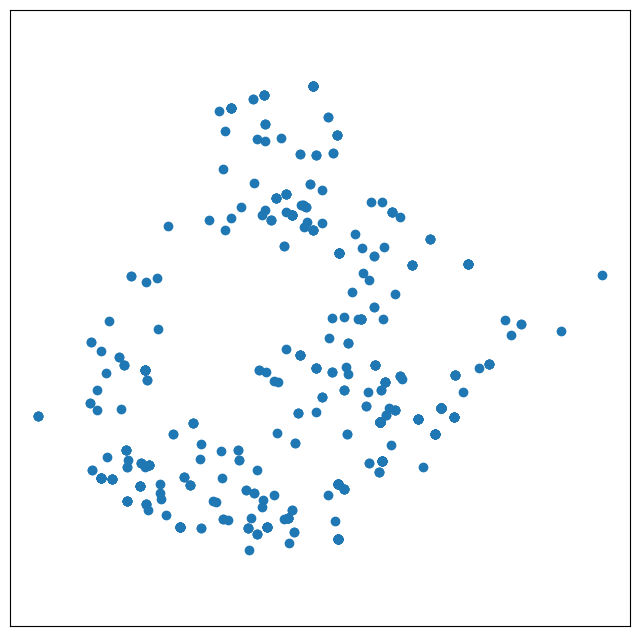

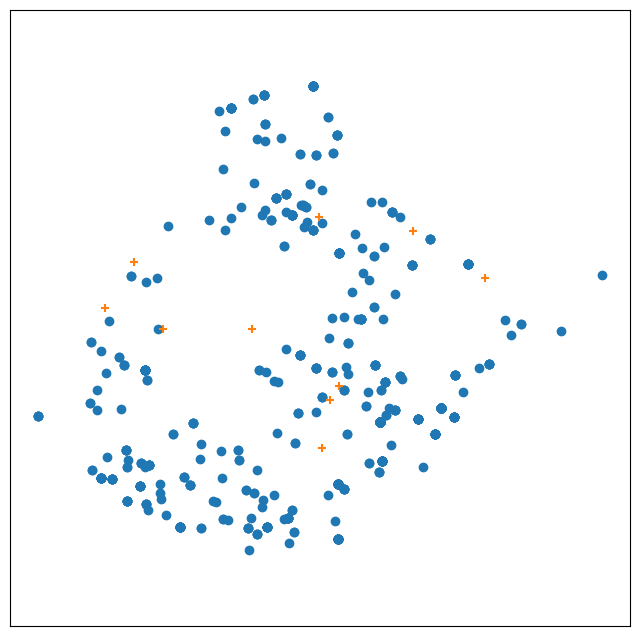

In [18]:
# Plot input data
plot_input(points)

# Number of sites to select
K = 10

# Service radius of each site
radius = 0.2

# Candidate site size (random sites generated)
M = 100

# Run mclp opt_sites is the location of optimal sites and f is the points covered
opt_sites,f = mclp(points,K,radius,M)

# Plot the result
plot_result(points,opt_sites,radius)